In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA   
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn import linear_model
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC


crime=pd.read_csv('database.csv')

/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/146279866.py:25: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  crime=pd.read_csv('database.csv')


In [9]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638454 entries, 0 to 638453
Data columns (total 24 columns):
 #   Column                 Non-Null Count   Dtype 
---  ------                 --------------   ----- 
 0   Record ID              638454 non-null  int64 
 1   Agency Code            638454 non-null  object
 2   Agency Name            638454 non-null  object
 3   Agency Type            638454 non-null  object
 4   City                   638454 non-null  object
 5   State                  638454 non-null  object
 6   Year                   638454 non-null  int64 
 7   Month                  638454 non-null  object
 8   Incident               638454 non-null  int64 
 9   Crime Type             638454 non-null  object
 10  Crime Solved           638454 non-null  object
 11  Victim Sex             638454 non-null  object
 12  Victim Age             638454 non-null  int64 
 13  Victim Race            638454 non-null  object
 14  Victim Ethnicity       638454 non-null  object
 15  

In [10]:
crime=crime.drop(["Record ID", "Agency Code", "Agency Name", "Agency Type", "Record Source"], axis=1)    

In [11]:
crime["Perpetrator Age"]=pd.to_numeric(crime["Perpetrator Age"], errors='coerce')

In [12]:
crime.sample(3)

,City,State,Year,Month,Incident,Crime Type,Crime Solved,Victim Sex,Victim Age,Victim Race,Victim Ethnicity,Perpetrator Sex,Perpetrator Age,Perpetrator Race,Perpetrator Ethnicity,Relationship,Weapon,Victim Count,Perpetrator Count
342873,Marion,Indiana,1996,December,3,Murder or Manslaughter,No,Male,22,Black,Unknown,Unknown,0.0,Unknown,Unknown,Unknown,Handgun,1,1
351479,El Paso,Texas,1996,November,2,Murder or Manslaughter,Yes,Male,16,White,Hispanic,Male,31.0,White,Hispanic,Stranger,Handgun,2,2
267320,Pima,Arizona,1993,November,3,Murder or Manslaughter,Yes,Male,28,White,Hispanic,Male,32.0,White,Hispanic,Stranger,Handgun,1,0


In [13]:
crime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 638454 entries, 0 to 638453
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   City                   638454 non-null  object 
 1   State                  638454 non-null  object 
 2   Year                   638454 non-null  int64  
 3   Month                  638454 non-null  object 
 4   Incident               638454 non-null  int64  
 5   Crime Type             638454 non-null  object 
 6   Crime Solved           638454 non-null  object 
 7   Victim Sex             638454 non-null  object 
 8   Victim Age             638454 non-null  int64  
 9   Victim Race            638454 non-null  object 
 10  Victim Ethnicity       638454 non-null  object 
 11  Perpetrator Sex        638454 non-null  object 
 12  Perpetrator Age        638453 non-null  float64
 13  Perpetrator Race       638454 non-null  object 
 14  Perpetrator Ethnicity  638454 non-nu

## Model with all features/columns included

In [107]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score

# Load data
crime = pd.read_csv('database.csv')
crime['Crime Solved'] = crime['Crime Solved'].map({'Yes': 1, 'No': 0})
crime["Perpetrator Age"]=pd.to_numeric(crime["Perpetrator Age"], errors='coerce')

# Convert to binary

# Define features and target
X = crime.drop('Crime Solved', axis=1)
y = crime['Crime Solved']

# Data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocessing pipelines
numerical_cols = X_train.select_dtypes(include=['number']).columns
categorical_cols = X_train.select_dtypes(exclude=['number']).columns

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='median')),
            ('scaler', StandardScaler())
        ]), numerical_cols),
        ('cat', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='most_frequent')),
            ('encoder', OneHotEncoder(handle_unknown='ignore'))
        ]), categorical_cols)
    ])

# Full pipeline with classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
print("Initial Classification Report:\n", classification_report(y_test, y_pred))

import numpy as np

feature_names = numerical_cols.tolist() + list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols))
coefficients = pipeline.named_steps['classifier'].coef_[0]

# Combine feature names and their coefficients
feature_importance = sorted(zip(feature_names, coefficients), key=lambda x: x[1], reverse=True)
print("Feature Importances:\n", feature_importance)

# Define a function to simplify the model iteratively
def simplify_model(X, y, features_to_remove):
    X_simplified = X.drop(columns=features_to_remove, errors='ignore')
    X_train, X_test, y_train, y_test = train_test_split(X_simplified, y, test_size=0.2, random_state=42)
    
    # Recreate the pipeline with remaining features
    numerical_cols = X_train.select_dtypes(include=['number']).columns
    categorical_cols = X_train.select_dtypes(exclude=['number']).columns

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler())
            ]), numerical_cols),
            ('cat', Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='most_frequent')),
                ('encoder', OneHotEncoder(handle_unknown='ignore'))
            ]), categorical_cols)
        ])
    
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
    ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    print("Simplified Model Accuracy:", accuracy)
    return accuracy

# Example of removing a set of features
simplify_model(X, y, ['some_low_importance_feature1', 'some_low_importance_feature2'])

from sklearn.model_selection import GridSearchCV

# Regularization with grid search
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],  # Regularization strengths
    'classifier__penalty': ['l1', 'l2']        # L1 and L2 regularization
}

grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)



/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_4723/1529323701.py:11: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  crime = pd.read_csv('database.csv')


Initial Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     37875
           1       1.00      1.00      1.00     89816

    accuracy                           1.00    127691
   macro avg       1.00      1.00      1.00    127691
weighted avg       1.00      1.00      1.00    127691

Feature Importances:
 [('Perpetrator Sex_Male', 5.584181104020533), ('Perpetrator Sex_Female', 4.644878128109741), ('Year', 2.522929915453797), ('Perpetrator Ethnicity_Not Hispanic', 1.5952760746587245), ('State_Florida', 1.3124258937497215), ('Victim Ethnicity_Unknown', 1.306381204549024), ('Perpetrator Ethnicity_Hispanic', 1.2310993687312417), ('City_St. Lucie', 1.2074996107358658), ('Agency Code_FL02901', 1.1284705218760815), ('Agency Name_Plant City', 1.1284705218760815), ('Agency Name_Hollywood', 1.0851461885235385), ('Agency Code_FL00605', 1.0851092438934509), ('Crime Type_Murder or Manslaughter', 1.0398411254997728), ('Agency 

## Eliminating features

/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_4723/3173827730.py:11: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  crime = pd.read_csv('database.csv')  # Adjust the path as necessary


Index(['Weapon', 'Relationship', 'Crime Solved', 'Incident', 'Crime Type',
       'Year', 'Month', 'City', 'Record ID', 'Agency Code', 'Agency Name',
       'Agency Type', 'State', 'Victim Sex', 'Victim Age', 'Victim Race',
       'Victim Ethnicity', 'Perpetrator Ethnicity', 'Victim Count',
       'Perpetrator Count', 'Record Source'],
      dtype='object')
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.88      0.85      1881
           1       0.95      0.92      0.94      4504

    accuracy                           0.91      6385
   macro avg       0.89      0.90      0.89      6385
weighted avg       0.91      0.91      0.91      6385

Accuracy:  0.9105716523101018
Best parameters: {'classifier__C': 0.1}
Best cross-validated accuracy: 0.9156555200310843


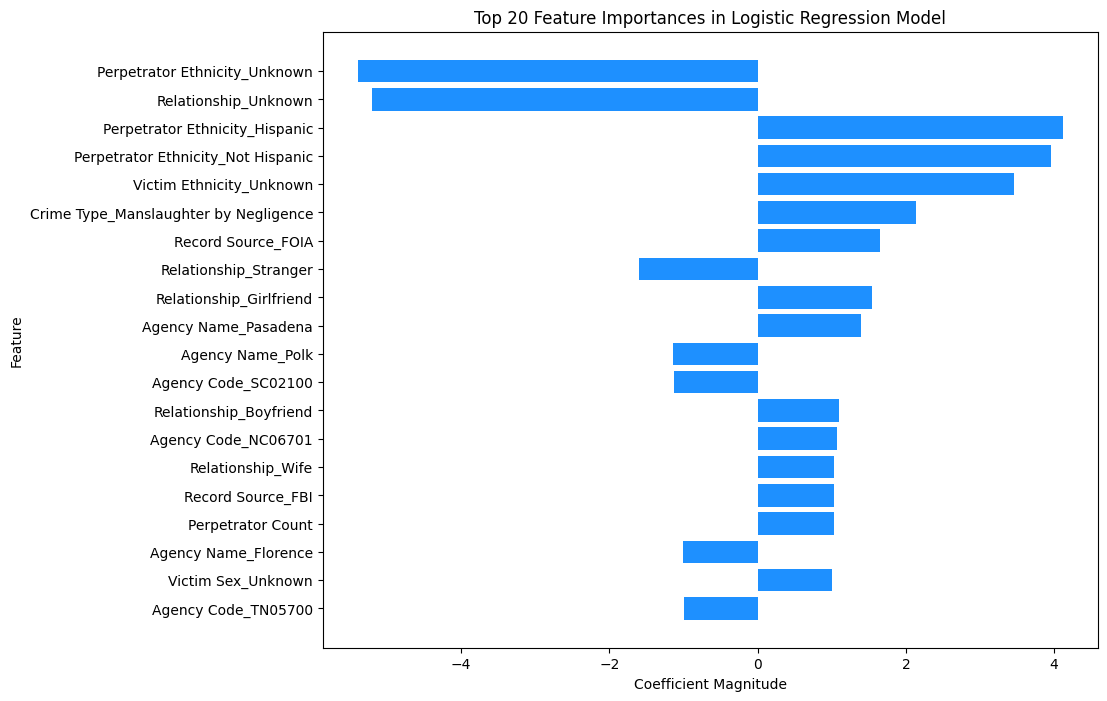

In [133]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
crime = pd.read_csv('database.csv')  # Adjust the path as necessary

# Assume 'Crime Solved' is binary and needs to be encoded
crime['Crime Solved'] = crime['Crime Solved'].map({'Yes': 1, 'No': 0})

# Drop columns that are not useful
#crime = crime.drop(["Record ID", "Agency Code", "Agency Name", "Agency Type", "Record Source", "Year", "Month", "Victim Count", "Perpetrator Count", "Victim Sex", "Victim Age", "Victim Race", "Victim Ethnicity", "Perpetrator Sex", "Perpetrator Age", "Perpetrator Race", "Perpetrator Ethnicity", "Victim Count"], axis=1)
crime=crime[["Weapon", "Relationship", "Crime Solved", "Incident", "Crime Type", "Year", "Month", "City", "Record ID", "Agency Code", "Agency Name", "Agency Type", "State", "Victim Sex", "Victim Age", "Victim Race", "Victim Ethnicity", "Perpetrator Ethnicity", "Victim Count", "Perpetrator Count", "Record Source"]]
print(crime.columns)

# Define features and target variable
X = crime.drop('Crime Solved', axis=1)
y = crime['Crime Solved']

# Stratified sampling to maintain class distribution
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)  # Using 5% of the data
for train_index, test_index in sss.split(X, y):
    X_sample, y_sample = X.iloc[test_index], y.iloc[test_index]

# Split the sampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=123)

# Identifying numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Creating preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Creating the full pipeline with logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_predicted = pipeline.predict(X_test)
print("Classification Report: \n", classification_report(y_test, y_predicted))
print("Accuracy: ", accuracy_score(y_test, y_predicted))

# Optional: Setting up GridSearchCV for hyperparameter tuning
param_grid = {
    'classifier__C': [0.1, 1.0, 10]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

import matplotlib.pyplot as plt
import numpy as np

# Assuming Logistic Regression is the classifier in the last step of the pipeline
feature_names = numerical_cols.tolist() + list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols))
coefficients = pipeline.named_steps['classifier'].coef_[0]

# Combine feature names and their coefficients
feature_importance = list(zip(feature_names, coefficients))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)  # Sort by absolute value of coefficients

# Splitting names and values for plotting
features, importance = zip(*feature_importance)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(features[:20], importance[:20], color='dodgerblue')  # Only display top 20 features
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances in Logistic Regression Model')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important at the top
plt.show()

#### When all features are included, the accuracy is close to 99.99654%, i.e incidacting that model is overfitiing. In other words, the ML learns perfect of training. After including and excluding all of the features, it was evidently clear that column "Perpetrator Sex" and "Perpetrator Age" caused the model to overfitt. 

#### To avoid baised model, I exclude all racial and ethnical features. So, the base model has the following features - "Weapon", "Relationship", "Crime Solved", "Incident", "Crime Type", "Victim Count", "Perpetrator Count". 

# LogisticRegression

/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_9724/2035390787.py:11: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  crime = pd.read_csv('database.csv')  # Adjust the path as necessary


Index(['Weapon', 'Relationship', 'Crime Solved', 'Incident', 'Crime Type',
       'Victim Count', 'Perpetrator Count'],
      dtype='object')
Classification Report: 
               precision    recall  f1-score   support

           0       0.70      0.88      0.78      1881
           1       0.94      0.84      0.89      4504

    accuracy                           0.85      6385
   macro avg       0.82      0.86      0.84      6385
weighted avg       0.87      0.85      0.86      6385

Accuracy:  0.8545027407987471
Best parameters: {'classifier__C': 1.0}
Best cross-validated accuracy: 0.8625577328030575


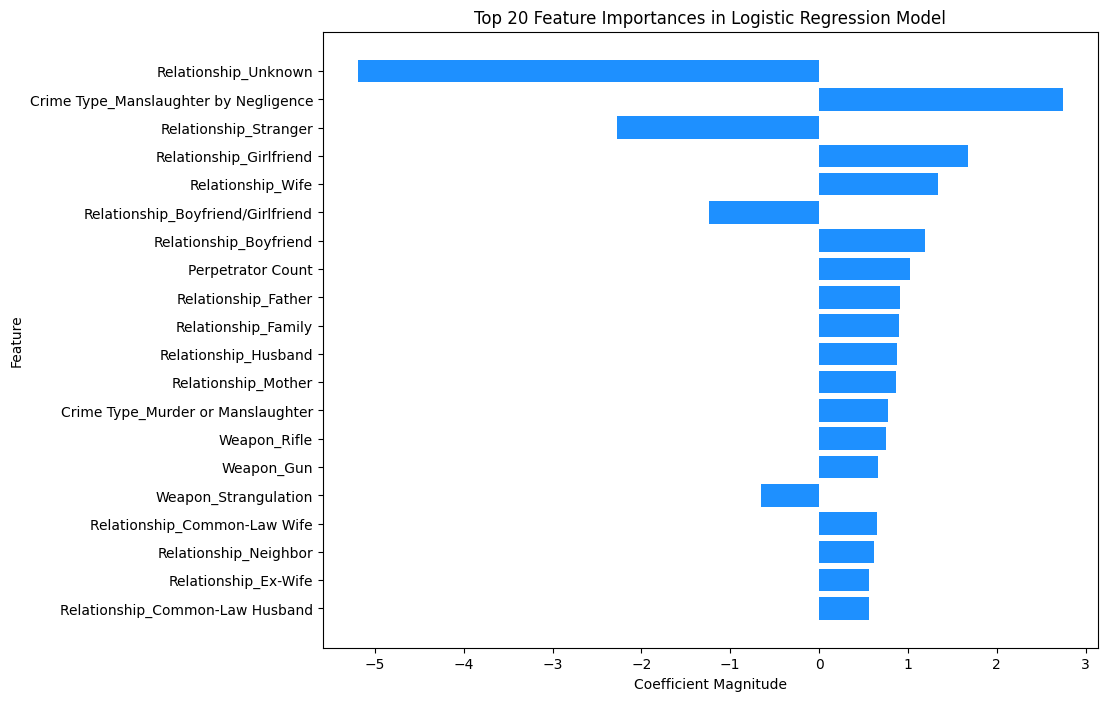

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset
crime = pd.read_csv('database.csv')  # Adjust the path as necessary

# Assume 'Crime Solved' is binary and needs to be encoded
crime['Crime Solved'] = crime['Crime Solved'].map({'Yes': 1, 'No': 0})

# Drop columns that are not useful
#crime = crime.drop(["Record ID", "Agency Code", "Agency Name", "Agency Type", "Record Source", "Year", "Month", "Victim Count", "Perpetrator Count", "Victim Sex", "Victim Age", "Victim Race", "Victim Ethnicity", "Perpetrator Sex", "Perpetrator Age", "Perpetrator Race", "Perpetrator Ethnicity", "Victim Count"], axis=1)
crime=crime[["Weapon", "Relationship", "Crime Solved", "Incident", "Crime Type", "Victim Count", "Perpetrator Count"]]
print(crime.columns)

# Define features and target variable
X = crime.drop('Crime Solved', axis=1)
y = crime['Crime Solved']

# Stratified sampling to maintain class distribution
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)  # Using 5% of the data
for train_index, test_index in sss.split(X, y):
    X_sample, y_sample = X.iloc[test_index], y.iloc[test_index]

# Split the sampled data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_sample, y_sample, test_size=0.2, random_state=123)

# Identifying numerical and categorical columns
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

# Creating preprocessing pipelines for numerical and categorical features
numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Creating the full pipeline with logistic regression
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(random_state=42, solver='liblinear'))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_predicted = pipeline.predict(X_test)
print("Classification Report: \n", classification_report(y_test, y_predicted))
print("Accuracy: ", accuracy_score(y_test, y_predicted))

# Optional: Setting up GridSearchCV for hyperparameter tuning
param_grid = {
    'classifier__C': [0.1, 1.0, 10]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

import matplotlib.pyplot as plt
import numpy as np

# Assuming Logistic Regression is the classifier in the last step of the pipeline
feature_names = numerical_cols.tolist() + list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols))
coefficients = pipeline.named_steps['classifier'].coef_[0]

# Combine feature names and their coefficients
feature_importance = list(zip(feature_names, coefficients))
feature_importance.sort(key=lambda x: abs(x[1]), reverse=True)  # Sort by absolute value of coefficients

# Splitting names and values for plotting
features, importance = zip(*feature_importance)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(features[:20], importance[:20], color='dodgerblue')  # Only display top 20 features
plt.xlabel('Coefficient Magnitude')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances in Logistic Regression Model')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important at the top
plt.show()

## LogisticRegression - Calculating the ROC cure and confusion matrix

/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/1166846974.py:11: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  crime = pd.read_csv('database.csv')


Initial data load: (638454, 24)
After mapping 'Yes' and 'No': [1 0]
Dropped 0 rows with NaN in 'Crime Solved'.
Data split successfully. Train and test sets are ready.


/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/1166846974.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_cols] = X_train[categorical_cols].astype(str)
/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/1166846974.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[categorical_cols] = X_test[categorical_cols].astype(str)


AUC Score: 0.9082792542595814
Precision: 0.9479639136719334
Recall: 0.8487214958275693
F1-Score: 0.8956018082501412
Confusion Matrix:
 [[ 8470  1044]
 [ 3390 19019]]


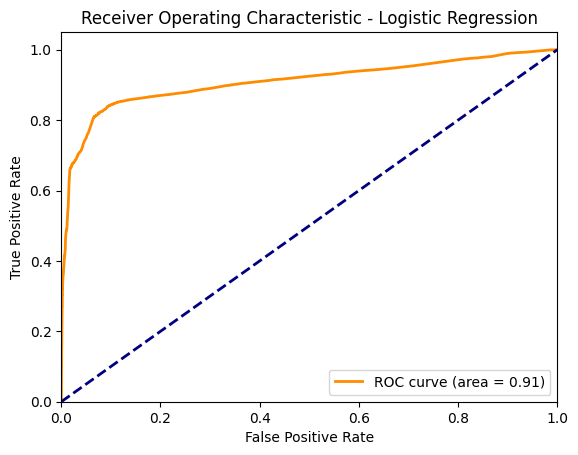

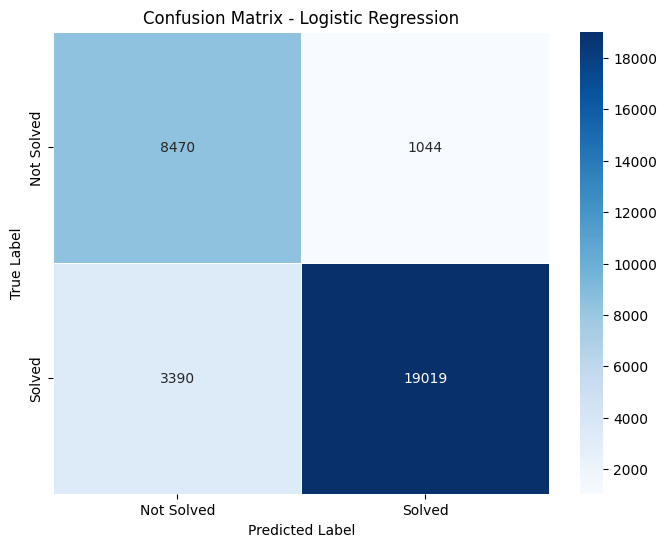

In [48]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score, roc_auc_score

# Load your data here
crime = pd.read_csv('database.csv')
print("Initial data load:", crime.shape)

# Map 'Crime Solved' and check for unintended NaNs
crime['Crime Solved'] = crime['Crime Solved'].map({'Yes': 1, 'No': 0})
print("After mapping 'Yes' and 'No':", crime['Crime Solved'].unique())

crime = crime[["Weapon", "Relationship", "Crime Solved", "Incident", "Crime Type", "Victim Count", "Perpetrator Count"]]

# Drop rows where 'Crime Solved' is NaN
initial_nan_count = crime['Crime Solved'].isnull().sum()
crime = crime.dropna(subset=['Crime Solved'])
print(f"Dropped {initial_nan_count} rows with NaN in 'Crime Solved'.")

# Ensure no rows are dropped if all were mapped correctly
if crime.empty:
    raise ValueError("All rows were dropped after handling 'Crime Solved'. Check mapping.")

X = crime.drop('Crime Solved', axis=1)
y = crime['Crime Solved']

# Final check before applying splits
if X.empty or y.empty:
    raise ValueError("X or y is empty after preprocessing. Check your data filtering steps.")

# Create and apply the StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("Data split successfully. Train and test sets are ready.")

# Define the preprocessing pipelines for numerical and categorical data
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Create the Logistic Regression pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)
# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_scores = pipeline.predict_proba(X_test)[:, 1]  # get probabilities for the positive class

# Calculate metrics
auc = roc_auc_score(y_test, y_scores)
precision = precision_score(y_test, y_pred, average='binary')

# Print results
print(f"AUC Score: {auc}")
print(f"Precision: {precision}")

from sklearn.metrics import roc_curve, auc, recall_score, f1_score, confusion_matrix

recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:\n", conf_matrix)


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Logistic Regression')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, cmap='Blues', xticklabels=['Not Solved', 'Solved'], yticklabels=['Not Solved', 'Solved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Logistic Regression')
plt.show()



# RandomForest

/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_9724/586670204.py:12: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  crime = pd.read_csv('database.csv')  # Adjust the path as necessary


Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.90      0.80      9514
           1       0.95      0.85      0.90     22409

    accuracy                           0.86     31923
   macro avg       0.83      0.87      0.85     31923
weighted avg       0.88      0.86      0.87     31923

Accuracy:  0.8641418413056418
Best parameters: {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}
Best cross-validated accuracy: 0.866808126872328


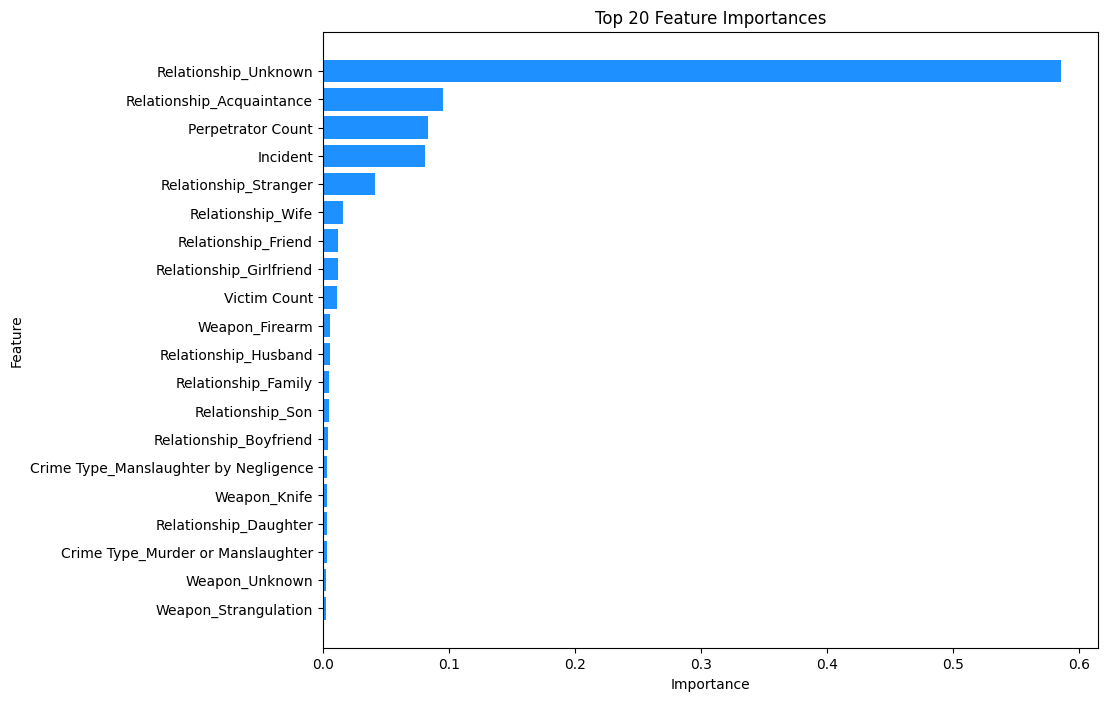

In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# Load the dataset
crime = pd.read_csv('database.csv')  # Adjust the path as necessary
crime['Crime Solved'] = crime['Crime Solved'].map({'Yes': 1, 'No': 0})  # Encoding

# Define the subset of columns to use
crime = crime[["Weapon", "Relationship", "Crime Solved", "Incident", "Crime Type", "Victim Count", "Perpetrator Count"]]

# Define features and target variable
X = crime.drop('Crime Solved', axis=1)
y = crime['Crime Solved']

# Stratified sampling to maintain class distribution
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Preprocessing pipelines
numerical_cols = ['Incident', 'Victim Count', 'Perpetrator Count']  # adjust as necessary
categorical_cols = ['Weapon', 'Relationship', 'Crime Type']  # adjust as necessary

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# RandomForest pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(random_state=42))
])

# Fit the model
pipeline.fit(X_train, y_train)

# Predict and evaluate the model
y_predicted = pipeline.predict(X_test)
print("Classification Report: \n", classification_report(y_test, y_predicted))
print("Accuracy: ", accuracy_score(y_test, y_predicted))

# GridSearchCV for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [100, 200],  # Reduced the number of estimators
    'classifier__max_depth': [None, 20],  # Focus on potentially higher depth, and unlimited
    'classifier__min_samples_split': [2, 10],  # Broad options for minimum samples split
    'classifier__min_samples_leaf': [1, 4],  # Minimal and a slightly higher option for leaves
    'classifier__max_features': ['sqrt'],  # Choose one, generally 'sqrt' is a good default
    'classifier__bootstrap': [True]  # Simplified to commonly used default
    # Removed 'max_leaf_nodes' to reduce complexity further
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)
print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.inspection import permutation_importance

# Feature importances from the Random Forest model
feature_names = numerical_cols + list(pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_cols))
importances = pipeline.named_steps['classifier'].feature_importances_
feature_importance = list(zip(feature_names, importances))
feature_importance.sort(key=lambda x: x[1], reverse=True)

# Plot
plt.figure(figsize=(10, 8))
features, importance = zip(*feature_importance[:20])
plt.barh(features, importance, color='dodgerblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 20 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

## RandomForest - Calculating the ROC cure and confusion matrix

/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/4269138113.py:11: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  crime = pd.read_csv('database.csv')


Initial data load: (638454, 24)
After mapping 'Yes' and 'No': [1 0]
Dropped 0 rows with NaN in 'Crime Solved'.
Data split successfully. Train and test sets are ready.


/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/4269138113.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_cols] = X_train[categorical_cols].astype(str)
/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/4269138113.py:78: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[categorical_cols] = X_test[categorical_cols].astype(str)


AUC Score: 0.917930164061665
Precision: 0.9536981358989778
Recall: 0.8493016198848677
F1-Score: 0.8984775168181282
Confusion Matrix:
 [[ 8590   924]
 [ 3377 19032]]


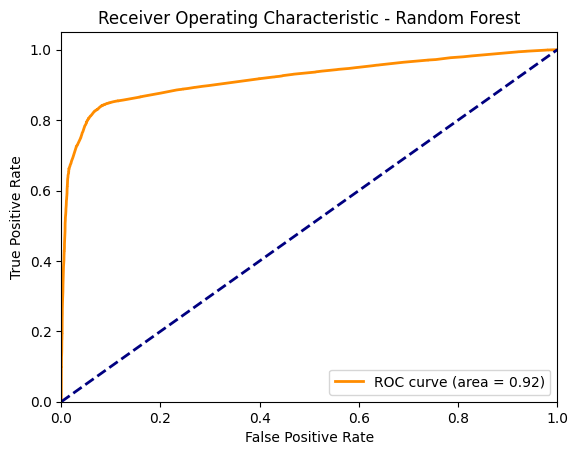

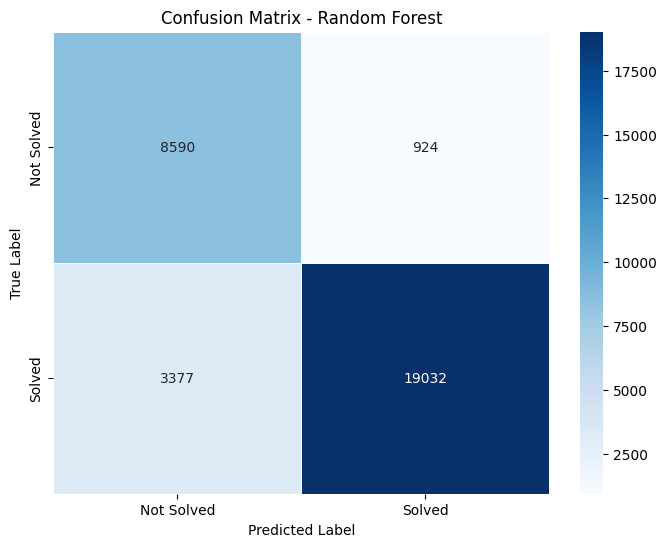

In [47]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, roc_auc_score

# Load your data here
crime = pd.read_csv('database.csv')
print("Initial data load:", crime.shape)

# Map 'Crime Solved' and check for unintended NaNs
crime['Crime Solved'] = crime['Crime Solved'].map({'Yes': 1, 'No': 0})
print("After mapping 'Yes' and 'No':", crime['Crime Solved'].unique())

crime = crime[["Weapon", "Relationship", "Crime Solved", "Incident", "Crime Type", "Victim Count", "Perpetrator Count"]]

# Drop rows where 'Crime Solved' is NaN
initial_nan_count = crime['Crime Solved'].isnull().sum()
crime = crime.dropna(subset=['Crime Solved'])
print(f"Dropped {initial_nan_count} rows with NaN in 'Crime Solved'.")

# Ensure no rows are dropped if all were mapped correctly
if crime.empty:
    raise ValueError("All rows were dropped after handling 'Crime Solved'. Check mapping.")

X = crime.drop('Crime Solved', axis=1)
y = crime['Crime Solved']

# Final check before applying splits
if X.empty or y.empty:
    raise ValueError("X or y is empty after preprocessing. Check your data filtering steps.")

# Create and apply the StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("Data split successfully. Train and test sets are ready.")

# Define the preprocessing pipelines for numerical and categorical data
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Create the Logistic Regression pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        bootstrap=True,
        max_depth=20,
        max_features='sqrt',
        min_samples_leaf=1,
        min_samples_split=2,
        n_estimators=200,
        random_state=42  # Optional for reproducibility
    ))
])

X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)
# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_scores = pipeline.predict_proba(X_test)[:, 1]  # get probabilities for the positive class

# Calculate metrics
auc = roc_auc_score(y_test, y_scores)
precision = precision_score(y_test, y_pred, average='binary')

# Print results
print(f"AUC Score: {auc}")
print(f"Precision: {precision}")

from sklearn.metrics import roc_curve, auc, recall_score, f1_score, confusion_matrix

recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:\n", conf_matrix)


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Random Forest')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, cmap='Blues', xticklabels=['Not Solved', 'Solved'], yticklabels=['Not Solved', 'Solved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Random Forest')
plt.show()

# XGBoost 

/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_9724/256703387.py:14: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  crime = pd.read_csv('database.csv')  # Adjust the path as necessary


Classification Report: 
               precision    recall  f1-score   support

           0       0.72      0.90      0.80      9514
           1       0.95      0.85      0.90     22409

    accuracy                           0.86     31923
   macro avg       0.83      0.88      0.85     31923
weighted avg       0.88      0.86      0.87     31923

Accuracy:  0.8644864204492059
Best parameters: {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__min_child_weight': 1}
Best cross-validated accuracy: 0.8668031807112909


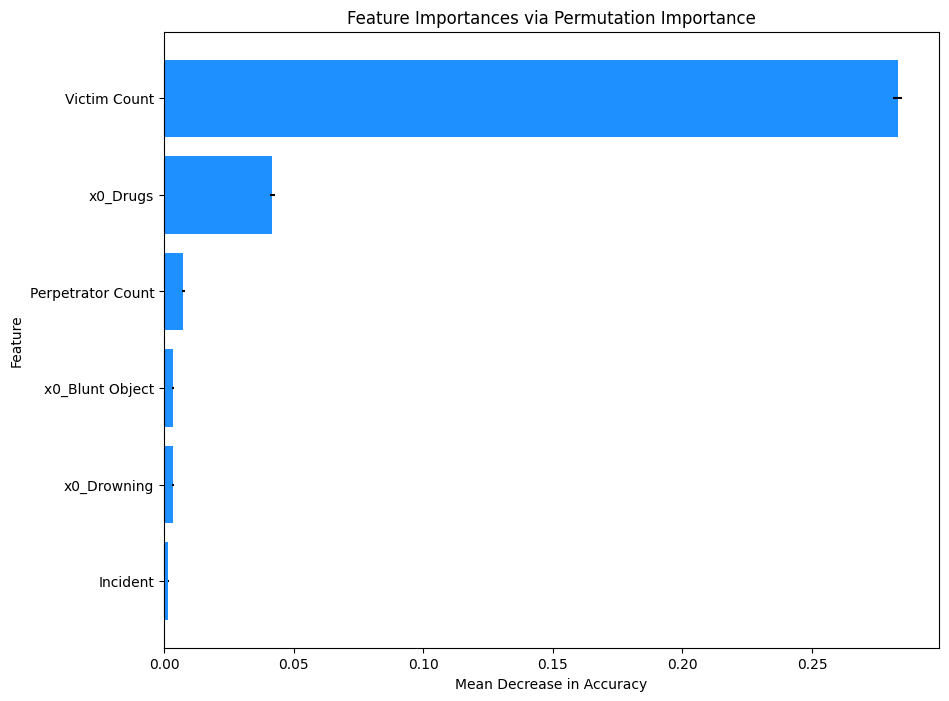

In [33]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance
import xgboost as xgb

import matplotlib.pyplot as plt

# Load the dataset
crime = pd.read_csv('database.csv')  # Adjust the path as necessary
crime['Crime Solved'] = crime['Crime Solved'].map({'Yes': 1, 'No': 0})  # Encoding

# Define the subset of columns to use
crime = crime[["Weapon", "Relationship", "Crime Solved", "Incident", "Crime Type", "Victim Count", "Perpetrator Count"]]

# Define features and target variable
X = crime.drop('Crime Solved', axis=1)
y = crime['Crime Solved']

# Stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Preprocessing pipelines
numerical_cols = ['Incident', 'Victim Count', 'Perpetrator Count']  # adjust as necessary
categorical_cols = ['Weapon', 'Relationship', 'Crime Type']  # adjust as necessary

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Model pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(random_state=42))
])

# Fit and evaluate
pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict(X_test)
print("Classification Report: \n", classification_report(y_test, y_predicted))
print("Accuracy: ", accuracy_score(y_test, y_predicted))

param_grid = {
    'classifier__max_depth': [3, 5, 7],
    'classifier__min_child_weight': [1, 5, 10],
    'classifier__learning_rate': [0.01, 0.1, 0.2]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)
# Calculate permutation importances
results = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importances and their standard deviations
importances = results.importances_mean
std_devs = results.importances_std

# Combine feature names and their importances
feature_names = numerical_cols + [name for name in pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out()]
feature_importance = list(zip(feature_names, importances, std_devs))
feature_importance.sort(key=lambda x: x[1], reverse=True)   # Sort by importance

# Splitting names, values, and errors for plotting
features, importance, std_dev = zip(*feature_importance[:20])

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(features, importance, xerr=std_dev, color='dodgerblue', align='center')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Feature')
plt.title('Feature Importances via Permutation Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important at the top
plt.show()

## XGBoost - Calculating the ROC curve and confusion matrix

/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/2962658558.py:11: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  crime = pd.read_csv('database.csv')


Initial data load: (638454, 24)
After mapping 'Yes' and 'No': [1 0]
Dropped 0 rows with NaN in 'Crime Solved'.
Data split successfully. Train and test sets are ready.


/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/2962658558.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_cols] = X_train[categorical_cols].astype(str)
/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/2962658558.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[categorical_cols] = X_test[categorical_cols].astype(str)


AUC Score: 0.9176935379680975
Precision: 0.9533600802407222
Recall: 0.8483198714802088
F1-Score: 0.897777987673853
Confusion Matrix:
 [[ 8584   930]
 [ 3399 19010]]


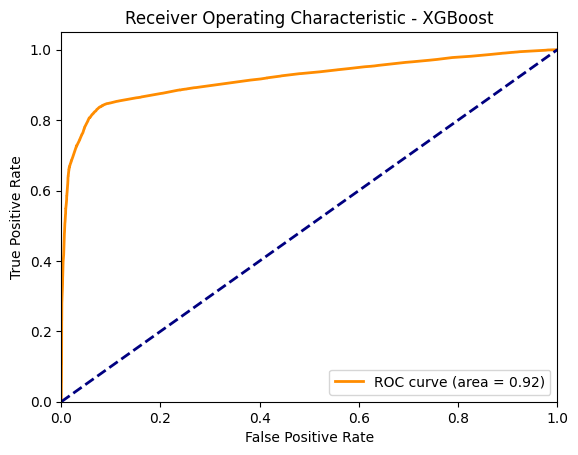

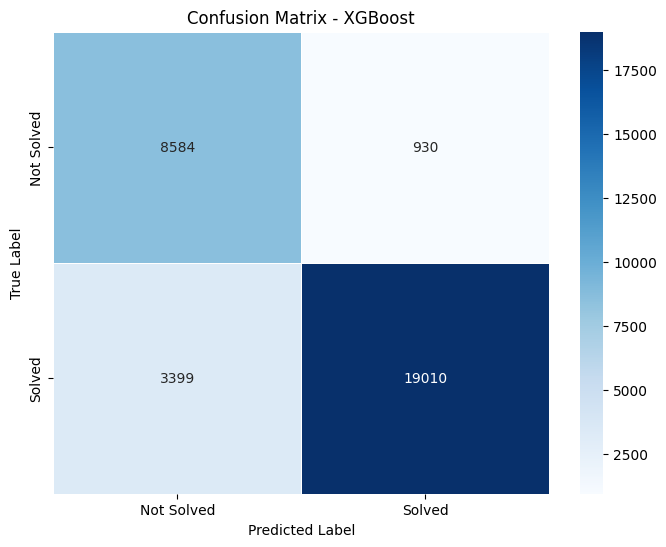

In [46]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, roc_auc_score
import xgboost as xgb

# Load your data here
crime = pd.read_csv('database.csv')
print("Initial data load:", crime.shape)

# Map 'Crime Solved' and check for unintended NaNs
crime['Crime Solved'] = crime['Crime Solved'].map({'Yes': 1, 'No': 0})
print("After mapping 'Yes' and 'No':", crime['Crime Solved'].unique())

crime = crime[["Weapon", "Relationship", "Crime Solved", "Incident", "Crime Type", "Victim Count", "Perpetrator Count"]]

# Drop rows where 'Crime Solved' is NaN
initial_nan_count = crime['Crime Solved'].isnull().sum()
crime = crime.dropna(subset=['Crime Solved'])
print(f"Dropped {initial_nan_count} rows with NaN in 'Crime Solved'.")

# Ensure no rows are dropped if all were mapped correctly
if crime.empty:
    raise ValueError("All rows were dropped after handling 'Crime Solved'. Check mapping.")

X = crime.drop('Crime Solved', axis=1)
y = crime['Crime Solved']

# Final check before applying splits
if X.empty or y.empty:
    raise ValueError("X or y is empty after preprocessing. Check your data filtering steps.")

# Create and apply the StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("Data split successfully. Train and test sets are ready.")

# Define the preprocessing pipelines for numerical and categorical data
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Create the Logistic Regression pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', xgb.XGBClassifier(
        learning_rate=0.2,
        max_depth=7,
        min_child_weight=1,
        random_state=42  # Optional for reproducibility
    ))
])

X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)
# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_scores = pipeline.predict_proba(X_test)[:, 1]  # get probabilities for the positive class

# Calculate metrics
auc = roc_auc_score(y_test, y_scores)
precision = precision_score(y_test, y_pred, average='binary')

# Print results
print(f"AUC Score: {auc}")
print(f"Precision: {precision}")

from sklearn.metrics import roc_curve, auc, recall_score, f1_score, confusion_matrix

recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:\n", conf_matrix)


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - XGBoost')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, cmap='Blues', xticklabels=['Not Solved', 'Solved'], yticklabels=['Not Solved', 'Solved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - XGBoost')
plt.show()

# DecisionTree

/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_9724/2277672776.py:15: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  crime = pd.read_csv('database.csv')  # Adjust the path as necessary


Classification Report: 
               precision    recall  f1-score   support

           0       0.71      0.90      0.80      9514
           1       0.95      0.85      0.90     22409

    accuracy                           0.86     31923
   macro avg       0.83      0.88      0.85     31923
weighted avg       0.88      0.86      0.87     31923

Accuracy:  0.8636719606553269


172389.19s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
172389.21s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
172389.24s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
172389.26s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
172389.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
172389.28s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
172389.31s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
172389.32s - pydevd: Sending message related to process being replaced timed-out after 5 seconds
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.01s - Debugger warning: It seems that frozen modules are being used, which may
0.00s - make the debugger miss breakpoints. Please pass -Xfroz

Best parameters: {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2}
Best cross-validated accuracy: 0.8660777437591815


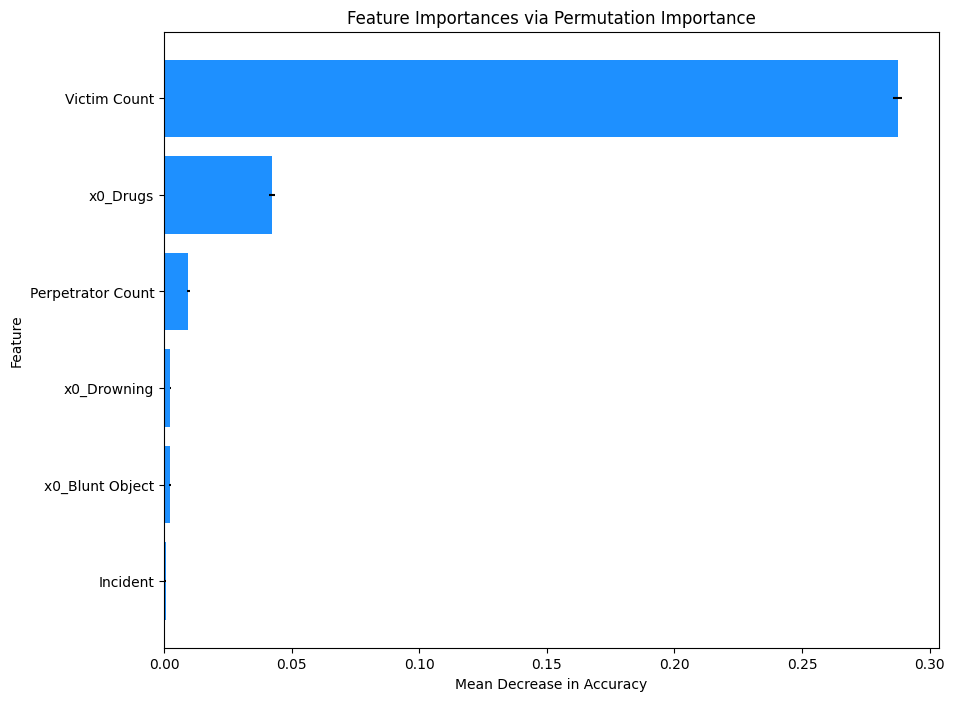

In [35]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier


import matplotlib.pyplot as plt

# Load the dataset
crime = pd.read_csv('database.csv')  # Adjust the path as necessary
crime['Crime Solved'] = crime['Crime Solved'].map({'Yes': 1, 'No': 0})  # Encoding

# Define the subset of columns to use
crime = crime[["Weapon", "Relationship", "Crime Solved", "Incident", "Crime Type", "Victim Count", "Perpetrator Count"]]

# Define features and target variable
X = crime.drop('Crime Solved', axis=1)
y = crime['Crime Solved']

# Stratified sampling
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

# Preprocessing pipelines
numerical_cols = ['Incident', 'Victim Count', 'Perpetrator Count']  # adjust as necessary
categorical_cols = ['Weapon', 'Relationship', 'Crime Type']  # adjust as necessary

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Model pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(max_depth=5, min_samples_split=20, random_state=42))
])

# Fit and evaluate
pipeline.fit(X_train, y_train)
y_predicted = pipeline.predict(X_test)
print("Classification Report: \n", classification_report(y_test, y_predicted))
print("Accuracy: ", accuracy_score(y_test, y_predicted))

param_grid = {
    'classifier__max_depth': [None, 5, 10, 15],
    'classifier__min_samples_split': [2, 10, 20],
    'classifier__min_samples_leaf': [1, 5, 10]
}
grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)
# Calculate permutation importances
results = permutation_importance(pipeline, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)

# Get the importances and their standard deviations
importances = results.importances_mean
std_devs = results.importances_std

# Combine feature names and their importances
feature_names = numerical_cols + [name for name in pipeline.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out()]
feature_importance = list(zip(feature_names, importances, std_devs))
feature_importance.sort(key=lambda x: x[1], reverse=True)   # Sort by importance

# Splitting names, values, and errors for plotting
features, importance, std_dev = zip(*feature_importance[:20])

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(features, importance, xerr=std_dev, color='dodgerblue', align='center')
plt.xlabel('Mean Decrease in Accuracy')
plt.ylabel('Feature')
plt.title('Feature Importances via Permutation Importance')
plt.gca().invert_yaxis()  # Invert the y-axis to have the most important at the top
plt.show()

## DecisionTree - Calculating the ROC curve and confusion matrix

/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/2737414298.py:11: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  crime = pd.read_csv('database.csv')


Initial data load: (638454, 24)
After mapping 'Yes' and 'No': [1 0]
Dropped 0 rows with NaN in 'Crime Solved'.
Data split successfully. Train and test sets are ready.


/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/2737414298.py:74: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train[categorical_cols] = X_train[categorical_cols].astype(str)
/var/folders/23/v45vdf3j7791ws_6xl_8l1hw0000gn/T/ipykernel_8871/2737414298.py:75: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[categorical_cols] = X_test[categorical_cols].astype(str)


AUC Score: 0.9154685134738717
Precision: 0.953525721455458
Recall: 0.8478289972778794
F1-Score: 0.8975764161194312
Confusion Matrix:
 [[ 8588   926]
 [ 3410 18999]]


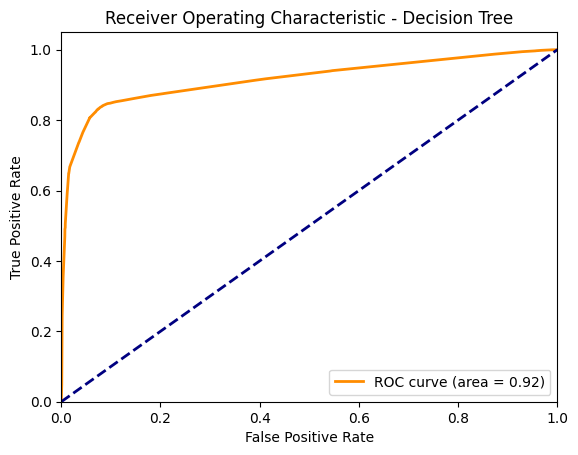

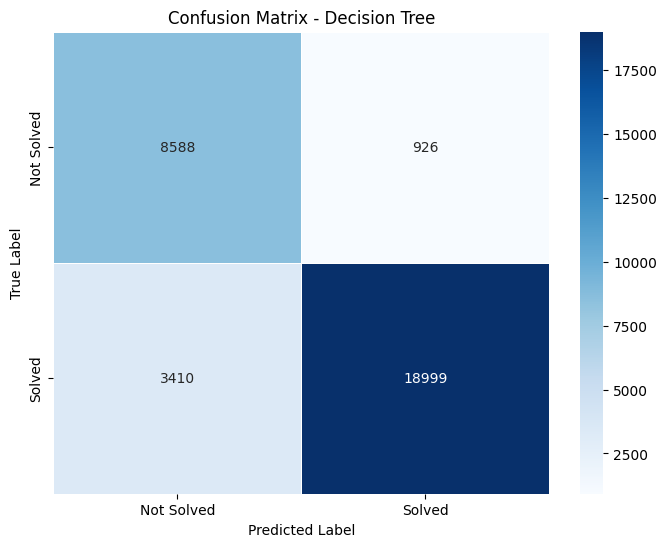

In [45]:
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import precision_score, roc_auc_score
from sklearn.tree import DecisionTreeClassifier

# Load your data here
crime = pd.read_csv('database.csv')
print("Initial data load:", crime.shape)

# Map 'Crime Solved' and check for unintended NaNs
crime['Crime Solved'] = crime['Crime Solved'].map({'Yes': 1, 'No': 0})
print("After mapping 'Yes' and 'No':", crime['Crime Solved'].unique())

crime = crime[["Weapon", "Relationship", "Crime Solved", "Incident", "Crime Type", "Victim Count", "Perpetrator Count"]]

# Drop rows where 'Crime Solved' is NaN
initial_nan_count = crime['Crime Solved'].isnull().sum()
crime = crime.dropna(subset=['Crime Solved'])
print(f"Dropped {initial_nan_count} rows with NaN in 'Crime Solved'.")

# Ensure no rows are dropped if all were mapped correctly
if crime.empty:
    raise ValueError("All rows were dropped after handling 'Crime Solved'. Check mapping.")

X = crime.drop('Crime Solved', axis=1)
y = crime['Crime Solved']

# Final check before applying splits
if X.empty or y.empty:
    raise ValueError("X or y is empty after preprocessing. Check your data filtering steps.")

# Create and apply the StratifiedShuffleSplit
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.05, random_state=42)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

print("Data split successfully. Train and test sets are ready.")

# Define the preprocessing pipelines for numerical and categorical data
numerical_cols = X_train.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = X_train.select_dtypes(include=['object']).columns

numerical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numerical_pipeline, numerical_cols),
    ('cat', categorical_pipeline, categorical_cols)
])

# Create the Logistic Regression pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(
        max_depth=10,
        min_samples_leaf=10,
        min_samples_split=2,
        random_state=42  # Optional for reproducibility
    ))
])

X_train[categorical_cols] = X_train[categorical_cols].astype(str)
X_test[categorical_cols] = X_test[categorical_cols].astype(str)
# Fit the model on the training data
pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = pipeline.predict(X_test)
y_scores = pipeline.predict_proba(X_test)[:, 1]  # get probabilities for the positive class

# Calculate metrics
auc = roc_auc_score(y_test, y_scores)
precision = precision_score(y_test, y_pred, average='binary')

# Print results
print(f"AUC Score: {auc}")
print(f"Precision: {precision}")

from sklearn.metrics import roc_curve, auc, recall_score, f1_score, confusion_matrix

recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print("Confusion Matrix:\n", conf_matrix)


from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Decision Tree')
plt.legend(loc="lower right")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", linewidths=.5, cmap='Blues', xticklabels=['Not Solved', 'Solved'], yticklabels=['Not Solved', 'Solved'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - Decision Tree')
plt.show()

# All results plots

In [3]:
import pandas as pd
param_grid = {
    "RandomForestClassifier": {"Accuracy":0.8641418413056418, "Best parameters": {'classifier__bootstrap': True, 'classifier__max_depth': 20, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 200}, "Best cross-validated accuracy": 0.866808126872328}, 
    "DecisionTreeClassifier": {"Accuracy": 0.8636719606553269, "Best parameters": {'classifier__max_depth': 10, 'classifier__min_samples_leaf': 10, 'classifier__min_samples_split': 2}, "Best cross-validated accuracy": 0.8660777437591815},
    "XGBoost":{"Accuracy": 0.8644864204492059, "Best parameters": {'classifier__learning_rate': 0.2, 'classifier__max_depth': 7, 'classifier__min_child_weight': 1}, "Best cross-validated accuracy": 0.8668031807112909}, 
    "LogisticRegression": {"Accuracy": 0.8545027407987471, "Best parameters": {'classifier__C': 1.0}, "Best cross-validated accuracy": 0.8625577328030575}
}

results = pd.DataFrame(param_grid).T


In [4]:
results

,Accuracy,Best parameters,Best cross-validated accuracy
RandomForestClassifier,0.864142,"{'classifier__bootstrap': True, 'classifier__m...",0.866808
DecisionTreeClassifier,0.863672,"{'classifier__max_depth': 10, 'classifier__min...",0.866078
XGBoost,0.864486,"{'classifier__learning_rate': 0.2, 'classifier...",0.866803
LogisticRegression,0.854503,{'classifier__C': 1.0},0.862558


AUC Score: 0.9082792542595814
Precision: 0.9479639136719334
Recall: 0.8487214958275693
F1-Score: 0.8956018082501412
Confusion Matrix:
 [[ 8470  1044]
 [ 3390 19019]]

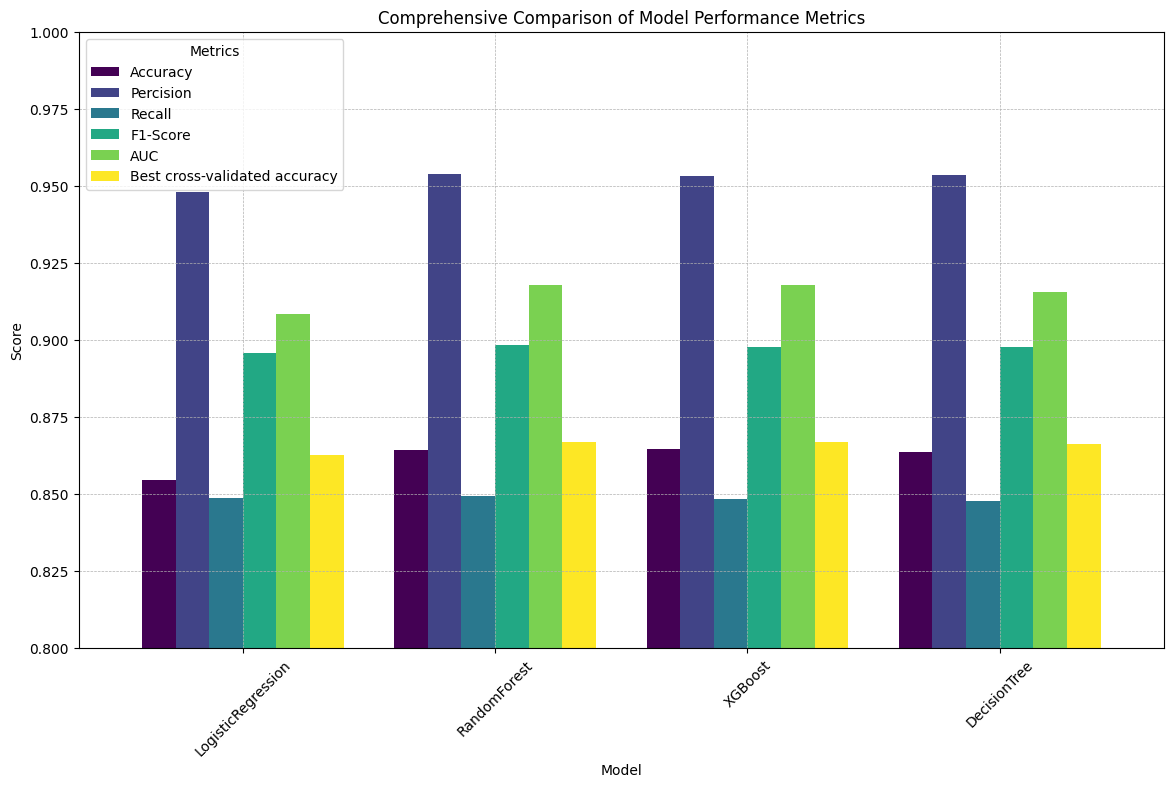

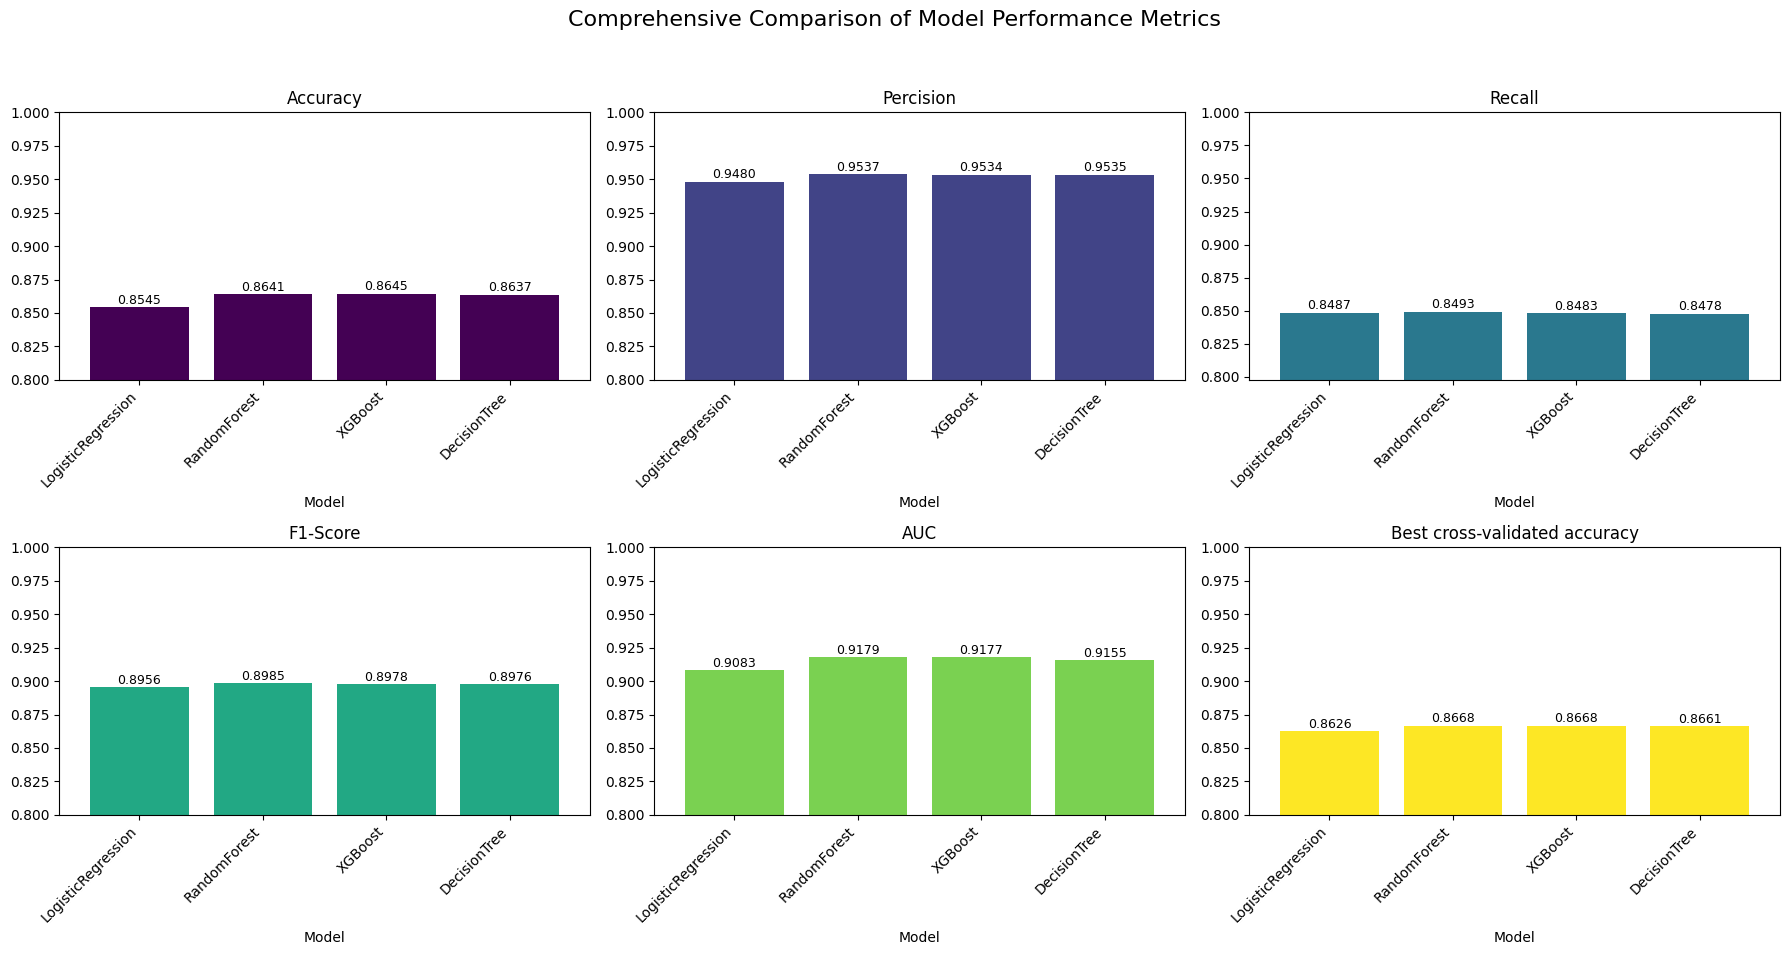

In [51]:
import pandas as pd
import matplotlib.pyplot as plt

# Example DataFrame
data = {
    'Model': ['LogisticRegression','RandomForest', 'XGBoost','DecisionTree'],
    'Accuracy': [0.854503, 0.864142, 0.864486, 0.863672],
    'Percision': [0.9479639136719334, 0.9536981358989778, 0.9533600802407222, 0.953525721455458],
    'Recall': [0.8487214958275693, 0.8493016198848677, 0.8483198714802088, 0.8478289972778794],
    'F1-Score': [0.8956018082501412, 0.8984775168181282, 0.897777987673853, 0.8975764161194312], 
    'AUC': [0.9082792542595814, 0.917930164061665, 0.9176935379680975, 0.9154685134738717],
    'Best cross-validated accuracy': [0.862558, 0.866808, 0.866803, 0.866078]
}

df = pd.DataFrame(data)

# Set the index to 'Model' to facilitate plotting
df.set_index('Model', inplace=True)

# Plotting
ax = df.plot(kind='bar', figsize=(14, 8), width=0.8, colormap='viridis')
ax.set_title('Comprehensive Comparison of Model Performance Metrics')
ax.set_ylabel('Score')
ax.set_ylim(0.8, 1.0)  # Adjust based on your specific data range
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.show()



# Create subplots
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
fig.suptitle('Comprehensive Comparison of Model Performance Metrics', fontsize=16)

# Define colors
colors = plt.cm.viridis(np.linspace(0, 1, len(df.columns)))

# Plot each metric in a separate subplot
for ax, (metric, color) in zip(axes.flatten(), zip(df.columns, colors)):
    df[metric].plot(kind='bar', ax=ax, color=color, width=0.8)
    ax.set_title(metric)
    ax.set_ylim(min(0.8, df[metric].min() - 0.05), 1.0)
    ax.set_xticklabels(df.index, rotation=45, ha='right')
    for p in ax.patches:
        ax.annotate(f'{p.get_height():.4f}', (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', fontsize=9, color='black', xytext=(0, 5),
                    textcoords='offset points')

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()
